# Maximum Likelihood Estimation (MLE) for parameters of univariate and multivariate normal distribution in PyTorch

In [1]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
dist = torch.distributions

#### Creating a 1d normal distribution

In [3]:
uv_normal = dist.Normal(loc=0.0, scale=1.0)

#### Sampling from the distribution

In [4]:
samples = uv_normal.sample(sample_shape=[1000])

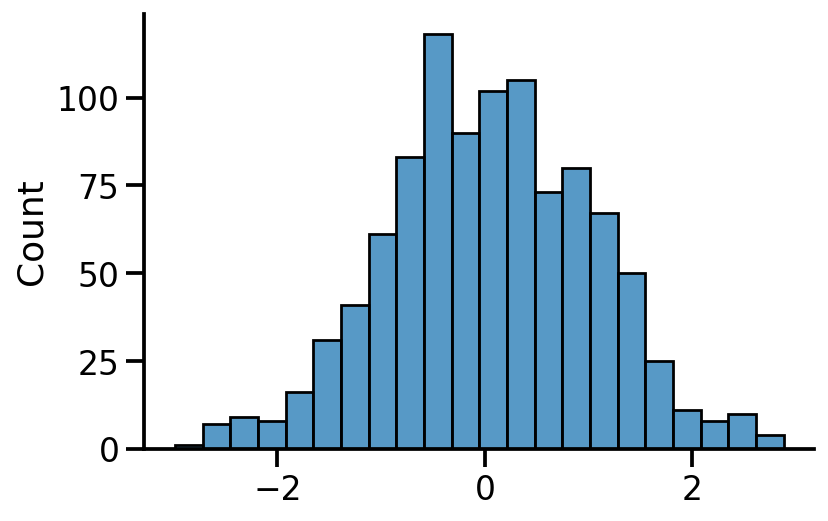

In [5]:
sns.histplot(samples)
sns.despine()

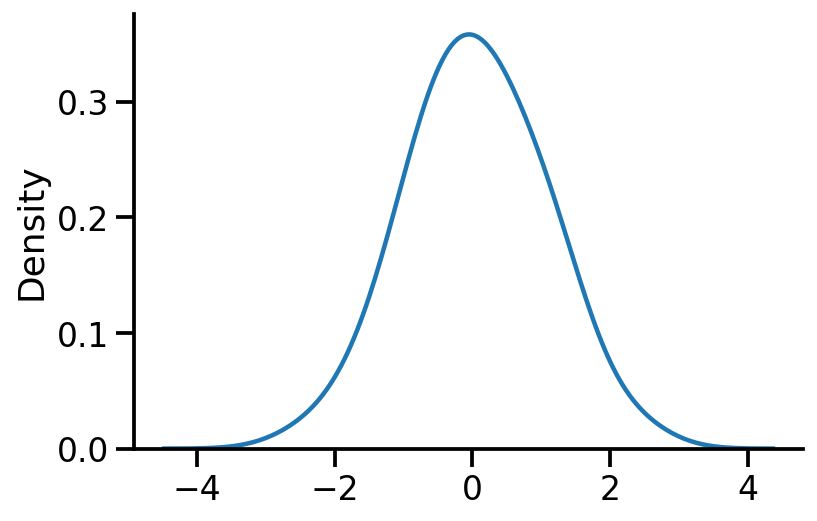

In [6]:
sns.kdeplot(samples, bw_adjust=2)
sns.despine()

#### Computing logprob and prob at a given x

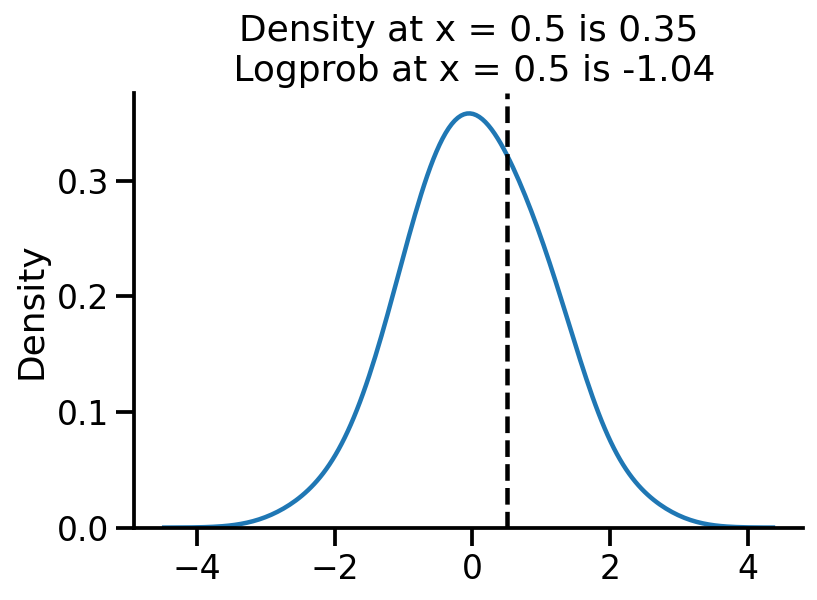

In [7]:
sns.kdeplot(samples, bw_adjust=2)
plt.axvline(0.5, color="k", linestyle="--")
log_pdf_05 = uv_normal.log_prob(torch.Tensor([0.5]))


pdf_05 = torch.exp(log_pdf_05)


plt.title(
    "Density at x = 0.5 is {:.2f}\n Logprob at x = 0.5 is {:.2f}".format(
        pdf_05.numpy()[0], log_pdf_05.numpy()[0]
    )
)
sns.despine()

#### Learning parameters via MLE

Let us generate some normally distributed data and see if we can `learn` the mean.

In [8]:
train_data = uv_normal.sample([10000])

In [9]:
uv_normal.loc, uv_normal.scale

(tensor(0.), tensor(1.))

In [10]:
train_data.mean(), train_data.std()

(tensor(-0.0174), tensor(1.0049))

The above is the analytical MLE solution

##### Setting 1: Fixed scale, learning only location

In [11]:
loc = torch.tensor(-10.0, requires_grad=True)
opt = torch.optim.Adam([loc], lr=0.01)
for i in range(3100):
    to_learn = torch.distributions.Normal(loc=loc, scale=1.0)
    loss = -torch.sum(to_learn.log_prob(train_data))
    loss.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc.item():0.2f}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 512500.16, Loc: -10.00
Iteration: 500, Loss: 170413.53, Loc: -5.61
Iteration: 1000, Loss: 47114.50, Loc: -2.58
Iteration: 1500, Loss: 18115.04, Loc: -0.90
Iteration: 2000, Loss: 14446.38, Loc: -0.22
Iteration: 2500, Loss: 14242.16, Loc: -0.05
Iteration: 3000, Loss: 14238.12, Loc: -0.02


In [12]:
print(
    f"MLE location gradient descent: {loc:0.2f}, MLE location analytical: {train_data.mean().item():0.2f}"
)

MLE location gradient descent: -0.02, MLE location analytical: -0.02


##### Setting 2: Learning location and scale

An important difference from the previous code is that we need to use a transformed variable to ensure scale is positive. We do so by using `softplus`.

In [13]:
loc = torch.tensor(-10.0, requires_grad=True)
scale = torch.tensor(2.0, requires_grad=True)

opt = torch.optim.Adam([loc, scale], lr=0.01)
for i in range(5100):
    scale_softplus = torch.functional.F.softplus(scale)

    to_learn = torch.distributions.Normal(loc=loc, scale=scale_softplus)
    loss = -torch.sum(to_learn.log_prob(train_data))
    loss.backward()
    if i % 500 == 0:
        print(
            f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc.item():0.2f}, Scale: {scale_softplus.item():0.2f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 127994.02, Loc: -10.00, Scale: 2.13
Iteration: 500, Loss: 37320.10, Loc: -6.86, Scale: 4.15
Iteration: 1000, Loss: 29944.32, Loc: -4.73, Scale: 4.59
Iteration: 1500, Loss: 26326.08, Loc: -2.87, Scale: 4.37
Iteration: 2000, Loss: 22592.90, Loc: -1.19, Scale: 3.46
Iteration: 2500, Loss: 15968.47, Loc: -0.06, Scale: 1.63
Iteration: 3000, Loss: 14237.87, Loc: -0.02, Scale: 1.01
Iteration: 3500, Loss: 14237.87, Loc: -0.02, Scale: 1.00
Iteration: 4000, Loss: 14237.87, Loc: -0.02, Scale: 1.00
Iteration: 4500, Loss: 14237.87, Loc: -0.02, Scale: 1.00
Iteration: 5000, Loss: 14237.87, Loc: -0.02, Scale: 1.00


In [14]:
print(
    f"MLE loc gradient descent: {loc:0.2f}, MLE loc analytical: {train_data.mean().item():0.2f}"
)
print(
    f"MLE scale gradient descent: {scale_softplus:0.2f}, MLE scale analytical: {train_data.std().item():0.2f}"
)

MLE loc gradient descent: -0.02, MLE loc analytical: -0.02
MLE scale gradient descent: 1.00, MLE scale analytical: 1.00


In [15]:
mvn = dist.MultivariateNormal(
    loc=torch.zeros(2), covariance_matrix=torch.tensor([[1.0, 0.5], [0.5, 2.0]])
)

In [16]:
mvn_samples = mvn.sample([1000])

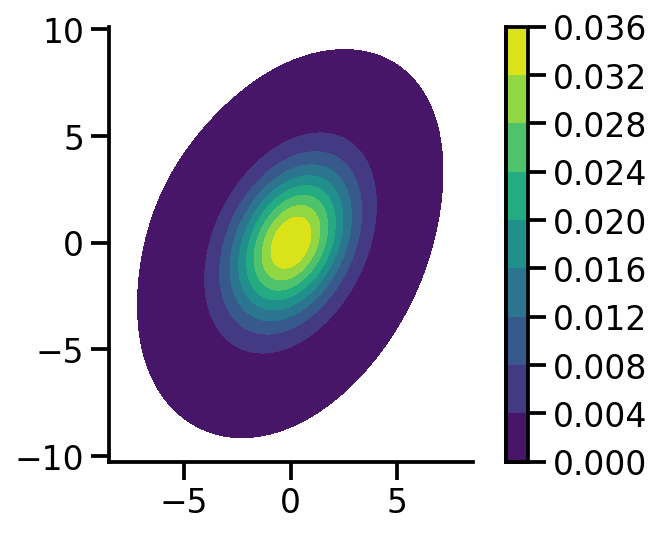

In [17]:
sns.kdeplot(
    x=mvn_samples[:, 0],
    y=mvn_samples[:, 1],
    zorder=0,
    n_levels=10,
    shade=True,
    cbar=True,
    thresh=0.001,
    cmap="viridis",
    bw_adjust=5,
    cbar_kws={
        "format": "%.3f",
    },
)

plt.gca().set_aspect("equal")
sns.despine()

##### Setting 1: Fixed scale, learning only location

In [18]:
loc = torch.tensor([-10.0, 5.0], requires_grad=True)
opt = torch.optim.Adam([loc], lr=0.01)
for i in range(4100):
    to_learn = dist.MultivariateNormal(
        loc=loc, covariance_matrix=torch.tensor([[1.0, 0.5], [0.5, 2.0]])
    )
    loss = -torch.sum(to_learn.log_prob(mvn_samples))
    loss.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 81817.08, Loc: tensor([-10.,   5.], requires_grad=True)
Iteration: 500, Loss: 23362.23, Loc: tensor([-5.6703,  0.9632], requires_grad=True)
Iteration: 1000, Loss: 7120.20, Loc: tensor([-2.7955, -0.8165], requires_grad=True)
Iteration: 1500, Loss: 3807.52, Loc: tensor([-1.1763, -0.8518], requires_grad=True)
Iteration: 2000, Loss: 3180.41, Loc: tensor([-0.4009, -0.3948], requires_grad=True)
Iteration: 2500, Loss: 3093.31, Loc: tensor([-0.0965, -0.1150], requires_grad=True)
Iteration: 3000, Loss: 3087.07, Loc: tensor([-0.0088, -0.0259], requires_grad=True)
Iteration: 3500, Loss: 3086.89, Loc: tensor([ 0.0073, -0.0092], requires_grad=True)
Iteration: 4000, Loss: 3086.88, Loc: tensor([ 0.0090, -0.0075], requires_grad=True)


In [19]:
loc, mvn_samples.mean(axis=0)

(tensor([ 0.0090, -0.0075], requires_grad=True), tensor([ 0.0090, -0.0074]))

We can see that our approach yields the same results as the analytical MLE

##### Setting 2: Learning scale and location

We need to now choose the equivalent of standard deviation in MVN case, this is the Cholesky matrix which should be a lower triangular matrix

In [20]:
loc = torch.tensor([-10.0, 5.0], requires_grad=True)
tril = torch.autograd.Variable(torch.tril(torch.ones(2, 2)), requires_grad=True)
opt = torch.optim.Adam([loc, tril], lr=0.01)

for i in range(8100):
    to_learn = dist.MultivariateNormal(loc=loc, covariance_matrix=tril @ tril.t())
    loss = -torch.sum(to_learn.log_prob(mvn_samples))
    loss.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 166143.42, Loc: tensor([-10.,   5.], requires_grad=True)
Iteration: 500, Loss: 9512.82, Loc: tensor([-7.8985,  3.2943], requires_grad=True)
Iteration: 1000, Loss: 6411.09, Loc: tensor([-6.4121,  2.5011], requires_grad=True)
Iteration: 1500, Loss: 5248.90, Loc: tensor([-5.0754,  1.8893], requires_grad=True)
Iteration: 2000, Loss: 4647.84, Loc: tensor([-3.8380,  1.3627], requires_grad=True)
Iteration: 2500, Loss: 4289.96, Loc: tensor([-2.6974,  0.9030], requires_grad=True)
Iteration: 3000, Loss: 4056.93, Loc: tensor([-1.6831,  0.5176], requires_grad=True)
Iteration: 3500, Loss: 3885.87, Loc: tensor([-0.8539,  0.2273], requires_grad=True)
Iteration: 4000, Loss: 3722.92, Loc: tensor([-0.2879,  0.0543], requires_grad=True)
Iteration: 4500, Loss: 3495.34, Loc: tensor([-0.0310, -0.0046], requires_grad=True)
Iteration: 5000, Loss: 3145.29, Loc: tensor([ 0.0089, -0.0075], requires_grad=True)
Iteration: 5500, Loss: 3080.54, Loc: tensor([ 0.0090, -0.0074], requires_grad=True)


In [21]:
to_learn.loc, to_learn.covariance_matrix

(tensor([ 0.0090, -0.0074], grad_fn=<AsStridedBackward0>),
 tensor([[1.0582, 0.4563],
         [0.4563, 1.7320]], grad_fn=<ExpandBackward0>))

In [22]:
mle_loc = mvn_samples.mean(axis=0)
mle_loc

tensor([ 0.0090, -0.0074])

In [23]:
mle_covariance = (
    (mvn_samples - mle_loc).t() @ ((mvn_samples - mle_loc)) / mvn_samples.shape[0]
)
mle_covariance

tensor([[1.0582, 0.4563],
        [0.4563, 1.7320]])

We can see that our gradient based methods parameters match those of the MLE computed analytically.

References

1. https://stats.stackexchange.com/questions/351549/maximum-likelihood-estimators-multivariate-gaussian
2. https://forum.pyro.ai/t/mle-for-normal-distribution-parameters/3861/3
3. https://ericmjl.github.io/notes/stats-ml/estimating-a-multivariate-gaussians-parameters-by-gradient-descent/